## SAS Exercise

### Program - cluster customers

In [8]:
* Read in customers data;
PROC IMPORT DATAFILE="data/Customers.xlsx"
		    OUT=customers
		    DBMS=XLSX
		    REPLACE;
RUN;


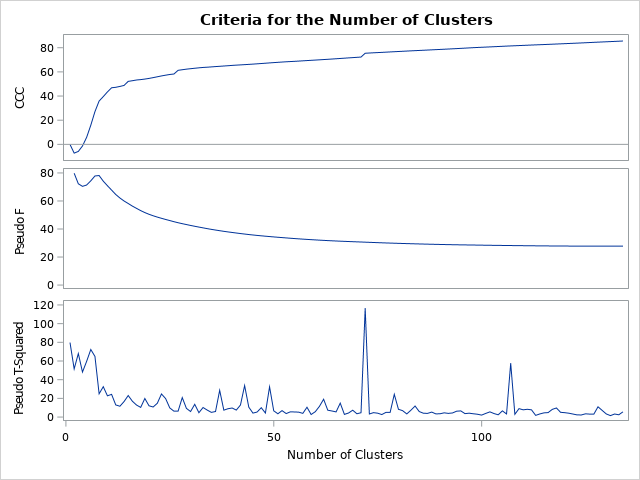

In [2]:
* Cluster the customers on all of their variables;
proc cluster data=customers standard outtree=customers_tree 
     method=ward ccc psedo;
     var income--prev_parent_mag;
run;

In [3]:
* Find the 8-cluster solution and add cluster number to dataset;
proc tree data=customers_tree nclusters=8 out=customers_ncl_8;
    copy _NUMERIC_; * Copy all numeric vars from input to output dataset;

![tree_customers](image/tree_customers.png)

In [4]:
proc means data=customers_ncl_8 n mean std;
    var income--prev_parent_mag;
    class cluster;
run;

SAS process has terminated unexpectedly. Pid State= posix.waitid_result(si_pid=15318, si_uid=1002, si_signo=17, si_status=0, si_code=1) 
Restarting SAS session on your behalf
in shutdown function
Restarting kernel...
Done!


'SAS process has terminated unexpectedly. Pid State= posix.waitid_result(si_pid=15318, si_uid=1002, si_signo=17, si_status=0, si_code=1)'

![mean_customers](image/mean_customers.png)

In [9]:
** Alternative clustering: K-means, via PROC FASTCLUS **;
* There is often an initial pre-clustering, followed by a clustering of the pre-clusters;
* Standardize customer data prior to using FASTCLUS, which lacks internal standardization;
* Method STD subtracts mean and divides by standard deviation;
proc stdize data=customers method=std out=std_customers;
    var income--prev_parent_mag;
run;

In [10]:
** K-means clustering: K=50 (pre-clusters)**;
* Get 50 preliminary seed clusters and store their centroids in MEAN= dataset;
proc fastclus data=std_customers mean=mean_std_fast_customers 
     maxclusters=50 maxiter=40;
     var income--prev_parent_mag;
run;

In [12]:
* Check quality of the 50 seeds by plotting inter-cluster gap and cluster radius vs number in cluster;
proc plot data=mean_std_fast_customers;
    plot _gap_*_freq_='g' _radius_*_freq_ = 'r'/vpos=25 hpos=50;
run;

In [13]:
* Delete low-count initial clusters (may not be necessary);
data mean_std_fast_customers;
    set mean_std_fast_customers;
    if _freq_ < 5 then delete;
run;

In [14]:
* Cluster the pre-clusters: K-means clustering: K=8;
* Use remaining seed clusters (SEED=) in FASTCLUS to get at most 8 clusters;
* Hopefully, the 8 will be from high frequency pre-clusters;
* Do not permit clusters more than distance=3 apart to join (STRICT=3) - limits outlier influence - may not be necessary; 
* Add cluster assignments to OUT= dataset;

proc fastclus data=std_customers seed = mean_std_fast_customers strict=3.0
              outseed = mean_std_fast_customers2
              out = out_mean_std_fast_customers maxclusters=8 maxiter=40;
   var income -- prev_parent_mag;
run;   

In [15]:
* Run FASTCLUS once more to assign remaining observations to clusters (MAXITER=0);
* Without this step, some cases may be assigned negative cluster numbers.;
* A negative value indicates that the case was not assigned to a cluster (see the STRICT option),;
* and the number is the cluster to which it would have been assigned.;
proc fastclus data=std_customers seed=mean_std_fast_customers2
              out = out_mean_std_fast_customers maxclusters=8 maxiter=0;
   var income--prev_parent_mag;
run;   


In [16]:
* Find how clusters differ from each other;
* Since FASTCLUS used standardized data, their means will be hard to interpret; 
* Extract K-means cluster number and add to CUSTOMERS dataset;
data fs_cluster;
    set out_mean_std_fast_customers;
    keep clusters;   * The only variable in the output dataset;
run;


In [17]:
* Side-by-side merge without matching control;
data customers;
    merge customers fs_cluster;
run;

In [23]:
proc means data=customers n mean std;
    var income--prev_parent_mag;
    class cluster;
run;    

![mean_customers2](image/mean_customers2.png)